In [44]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
def scale_usage(df, column_name, scale_factor):
    """Escala el consumo del total a una sola unidad (CPU/GPU)."""
    df[column_name] = df[column_name] * scale_factor
    return df

def load_and_truncate(files, column_name, execution_times, window, scale_factor=1):
    """Carga, filtra y escala los consumos de CPU o GPU."""
    all_iterations = []
    for i, file in enumerate(files):
        if i < len(execution_times):
            exec_time = int(execution_times.loc[i, "execution_time"])
            df = pd.read_csv(file, header=None, names=[column_name]).dropna()
            df[column_name] = df[column_name].apply(lambda x: float(x.split("%")[0]))
            df = df.head(exec_time)
            df["time_instant"] = range(len(df))
            df[column_name] = df[column_name].rolling(window=window, min_periods=1).mean()
            df = scale_usage(df, column_name, scale_factor)  # Escalar valores a una CPU/GPU
            all_iterations.append(df)
    if all_iterations:
        return pd.concat(all_iterations).groupby("time_instant", as_index=False).mean()
    return pd.DataFrame(columns=["time_instant", column_name])

def load_and_truncate_gpu(files, column_name, execution_times, window, num_gpus=3):
    """Carga, agrupa por GPUs y calcula el promedio de consumo en el tiempo."""
    all_iterations = []
    for i, file in enumerate(files):
        if i < len(execution_times):
            exec_time = int(execution_times.loc[i, "execution_time"])
            # Leer archivo y convertir a lista de consumos
            df = pd.read_csv(file, header=None, names=[column_name]).dropna()
            df[column_name] = df[column_name].apply(lambda x: float(x.split("%")[0]))
            df = df.head(exec_time)  # Limitar al tiempo de ejecución

            # Agrupar filas en bloques de num_gpus y calcular el promedio por instante de tiempo
            df["gpu_id"] = df.index % num_gpus  # Asignar IDs de GPU (0, 1, ..., num_gpus-1)
            grouped_df = df.groupby(df.index // num_gpus).mean()  # Agrupar en bloques de num_gpus
            grouped_df = grouped_df.rename_axis("time_instant").reset_index()
            grouped_df[column_name] = grouped_df[column_name].rolling(window=window, min_periods=1).mean()
            all_iterations.append(grouped_df)
    if all_iterations:
        return pd.concat(all_iterations).groupby("time_instant", as_index=False).mean()
    return pd.DataFrame(columns=["time_instant", column_name])

In [46]:
title_size = 24
axis_label_size = 24
tick_label_size = 22
legend_size = 22

# Paleta de colores única
palette = ["#28ABB9", "#F18D35", "#4CB944", "#E63946"]  # Blue, Orange, Green, Red
linewidth = 2.5
filter_window = 20

In [57]:
path_models = "/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/data/models_v3"
exec_time_file = glob.glob(f"{path_models}/traco/cancer/execution_times.csv")
execution_times = pd.read_csv(exec_time_file[0])
execution_times = execution_times.rename(columns={"Execution Time (s)": "execution_time"})
exec_time = int(execution_times.loc[0, "execution_time"])
exec_time

1036

In [81]:
file_cpu = glob.glob(f"{path_models}/traco/cancer/cpu_usage_iter.1.csv")[0]
file_gpu = glob.glob(f"{path_models}/traco/cancer/gpu_usage_iter.1.csv")[0]
print(file_cpu)
print(file_gpu)

/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/data/models_v3/traco/cancer/cpu_usage_iter.1.csv
/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/data/models_v3/traco/cancer/gpu_usage_iter.1.csv


In [83]:
df = pd.read_csv(file_cpu, header=None, names=["cpu"]).dropna()
df["cpu"] = df["cpu"].apply(lambda x: float(x.split("%")[0]))
df = df.head(exec_time)
df["time_instant"] = range(len(df))
df["cpu"] = df["cpu"].rolling(window=5, min_periods=1).mean()
df = scale_usage(df, "cpu", 96)  # Escalar valores a una CPU/GPU
df

,cpu,time_instant
0,3436.80,0
1,1819.20,1
2,1273.60,2
3,998.40,3
4,833.28,4
...,...,...
810,433.92,810
811,432.00,811
812,424.32,812
813,399.36,813


In [78]:
df = pd.read_csv(file_gpu, header=None, names=["gpu"]).dropna()
df["gpu"] = df["gpu"].apply(lambda x: float(x.split("%")[0]))
#df = df.head(exec_time*3)  # Limitar al tiempo de ejecución
grouped_df = df.groupby(df.index // 3).mean()  # Agrupar en bloques de num_gpus
grouped_df = grouped_df.rename_axis("time_instant").reset_index()
grouped_df["gpu"] = grouped_df["gpu"].rolling(window=5, min_periods=1).mean()
grouped_df

,gpu
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2827,0.0
2828,0.0
2829,0.0
2830,0.0


In [79]:
grouped_df = df.groupby(df.index // 3).mean()  # Agrupar en bloques de num_gpus
grouped_df = grouped_df.rename_axis("time_instant").reset_index()
grouped_df["gpu"] = grouped_df["gpu"].rolling(window=5, min_periods=1).mean()
grouped_df

,time_instant,gpu
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
939,939,0.0
940,940,0.0
941,941,0.0
942,942,0.0


In [59]:
2765/96

28.802083333333332

In [ ]:
df = df.head(exec_time)
df["time_instant"] = range(len(df))
df[column_name] = df[column_name].rolling(window=window, min_periods=1).mean()
df = scale_usage(df, column_name, scale_factor)  # Escalar valores a una CPU/GPU

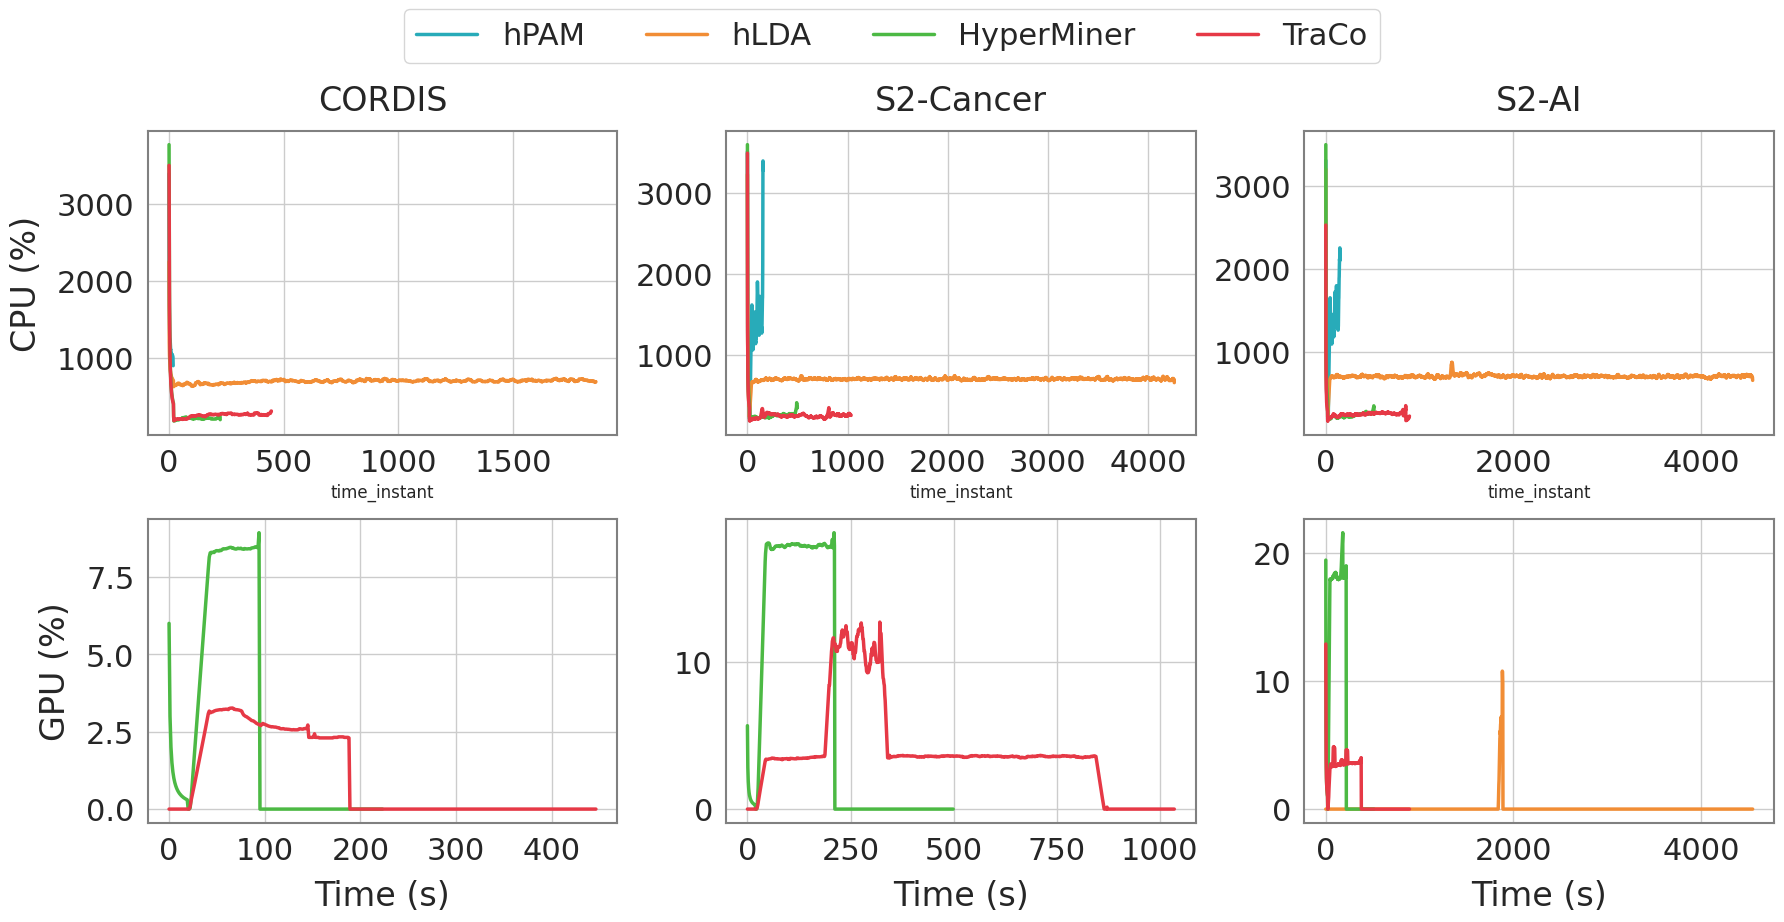

In [47]:
# Configuración del estilo y colores
sns.set_theme(style="whitegrid", rc={"axes.edgecolor": "gray", "axes.linewidth": 1.5})
linewidth = 2.5
filter_window = 20

# Procesar los datos
# Diccionario para mapear nombres de archivos a nombres bonitos
algorithm_names = {
    "hpam": "hPAM",
    "hlda": "hLDA",
    "hyperminer": "HyperMiner",
    "traco": "TraCo"
}
datset_names = {
    "cordis": "CORDIS",
    "cancer": "S2-Cancer",
    "ai": "S2-AI"
}
# Procesar los datos
all_data = []
path_models = "/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/data/models_v3"
algorithms = ["hpam", "hlda", "hyperminer", "traco"]  # Nombres en minúsculas para archivos
datasets = ["cordis", "cancer", "ai"]

for algo in algorithms:
    for dtset in datasets:
        exec_time_file = glob.glob(f"{path_models}/{algo}/{dtset}/execution_times.csv")
        if exec_time_file:
            execution_times = pd.read_csv(exec_time_file[0])
            execution_times = execution_times.rename(columns={"Execution Time (s)": "execution_time"})
        else:
            continue

        cpu_files = glob.glob(f"{path_models}/{algo}/{dtset}/cpu_usage_iter.*.csv")
        gpu_files = glob.glob(f"{path_models}/{algo}/{dtset}/gpu_usage_iter.*.csv")
        df_cpu = load_and_truncate(cpu_files, "cpu", execution_times, filter_window, scale_factor=96)
        df_gpu = load_and_truncate_gpu(gpu_files, "gpu", execution_times, filter_window, num_gpus=3)

        df_combined = pd.merge(df_cpu, df_gpu, on="time_instant", how="outer").fillna(0)
        df_combined["algorithm"] = algorithm_names[algo]  # Usar nombres formateados
        df_combined["dataset"] = dtset
        all_data.append(df_combined)

usage_data = pd.concat(all_data, ignore_index=True)

# Visualización mejorada
fig, axs = plt.subplots(2, len(datasets), figsize=(18, 9), sharex=False, sharey=False)

for col, dataset in enumerate(datasets):
    subset = usage_data[usage_data["dataset"] == dataset]
    ax_cpu = axs[0, col]
    ax_gpu = axs[1, col]

    for i, algo in enumerate(algorithm_names.values()):
        algo_data = subset[subset["algorithm"] == algo]
        algo_data_zoom = algo_data[algo_data["time_instant"] <= 5000]
        
        # CPU (línea sólida)
        sns.lineplot(
            data=algo_data_zoom, x="time_instant", y="cpu", ax=ax_cpu, 
            color=palette[i], linewidth=linewidth, label=algo if col == 0 else None
        )
        
        # GPU (línea punteada) solo si el consumo no es 0
        if algo_data_zoom["gpu"].sum() > 0:  
            sns.lineplot(
                data=algo_data_zoom, x="time_instant", y="gpu", ax=ax_gpu, 
                color=palette[i], linewidth=linewidth, label=None
            )

    # Eliminar leyendas de los subgráficos
    if ax_cpu.get_legend() is not None:
        ax_cpu.get_legend().remove()
    if ax_gpu.get_legend() is not None:
        ax_gpu.get_legend().remove()

    # Mostrar etiquetas solo en la primera columna
    if col == 0:
        ax_cpu.set_ylabel("CPU (%)", fontsize=axis_label_size, labelpad=10)
        ax_gpu.set_ylabel("GPU (%)", fontsize=axis_label_size, labelpad=10)
    else:
        ax_cpu.set_ylabel("")
        ax_gpu.set_ylabel("")
    
    # Mostrar títulos solo en la primera fila
    if ax_cpu == axs[0, col]:
        ax_cpu.set_title(f"{datset_names[dataset]}", fontsize=title_size, pad=15)

    # Configuración del eje X
    ax_gpu.set_xlabel("Time (s)", fontsize=axis_label_size, labelpad=10)
    ax_cpu.tick_params(axis='both', labelsize=tick_label_size)
    ax_gpu.tick_params(axis='both', labelsize=tick_label_size)

# Leyenda global
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=4, fontsize=legend_size)

# Ajustes finales
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("cpu_gpu_usage_baselines.png", dpi=300, bbox_inches="tight")
plt.show()

In [48]:
import pandas as pd

# Calcular promedios y desviación estándar por modelo y dataset
summary_table = usage_data.groupby(["algorithm", "dataset"]).agg(
    avg_cpu_usage=("cpu", "mean"),
    std_cpu_usage=("cpu", "std"),
    avg_gpu_usage=("gpu", "mean"),
    std_gpu_usage=("gpu", "std"),
    avg_time=("time_instant", "max")
).reset_index()

# Redondear valores
summary_table["avg_cpu_usage"] = summary_table["avg_cpu_usage"].round(2)
summary_table["std_cpu_usage"] = summary_table["std_cpu_usage"].round(2)
summary_table["avg_gpu_usage"] = summary_table["avg_gpu_usage"].round(2)
summary_table["std_gpu_usage"] = summary_table["std_gpu_usage"].round(2)
summary_table["avg_time"] = (summary_table["avg_time"] / 60).round(2)

# Ordenar los datasets en el orden deseado
desired_order = ["cordis", "cancer", "ai"]
summary_table["dataset"] = pd.Categorical(summary_table["dataset"], categories=desired_order, ordered=True)
summary_table = summary_table.sort_values("dataset")

# Crear la tabla final manualmente
datasets = summary_table["dataset"].unique()
algorithms = summary_table["algorithm"].unique()

final_table = pd.DataFrame(index=algorithms)

for dataset in datasets:
    dataset_str = str(dataset).upper()  # Convertir dataset a string en mayúsculas
    # Formatear CPU y GPU como "promedio ± desviación"
    cpu_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm").apply(
        lambda row: f"{row['avg_cpu_usage']} ± {row['std_cpu_usage']}", axis=1
    )
    gpu_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm").apply(
        lambda row: f"{row['avg_gpu_usage']} ± {row['std_gpu_usage']}", axis=1
    )
    time_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm")["avg_time"]
    
    final_table[(dataset_str, "CPU (%)")] = cpu_col
    final_table[(dataset_str, "GPU (%)")] = gpu_col
    final_table[(dataset_str, "Time (min)")] = time_col

# Reconstruir MultiIndex para columnas
final_table.columns = pd.MultiIndex.from_tuples(final_table.columns)

# Generar LaTeX manualmente con ajustes de encabezado
latex_output = "\\begin{table}\n"
latex_output += "\\caption{Consumo promedio total de CPU, GPU (con desviación estándar) y tiempo de ejecución por modelo y dataset}\n"
latex_output += "\\label{tab:cpu_gpu_usage_total}\n"
latex_output += "\\centering\n"
latex_output += "\\resizebox{\\columnwidth}{!}{%\n"
latex_output += "\\begin{tabular}{llrlrlrlrl}\n"
latex_output += "\\toprule\n"

# Añadir encabezados centrados para datasets
datasets_latex = " & ".join([f"\\multicolumn{{3}}{{c}}{{{dataset}}}" for dataset in ["CORDIS", "CANCER", "AI"]])
latex_output += f" & {datasets_latex} \\\\\n"

# Añadir líneas horizontales parciales debajo de los encabezados
cmidrule_lines = " ".join(
    [f"\\cmidrule(lr){{{3*i+2}-{3*i+4}}}" for i in range(len(datasets))]
)
latex_output += f"{cmidrule_lines}\n"

# Añadir nombres de columnas secundarias
latex_output += " & CPU Usage & GPU Usage & Time (min)" * len(datasets) + " \\\\\n"
latex_output += "\\midrule\n"

# Añadir datos de la tabla
for algorithm in algorithms:
    row = final_table.loc[algorithm].values
    row_str = " & ".join([str(cell) if not pd.isna(cell) else "N/A" for cell in row])
    latex_output += f"{algorithm} & {row_str} \\\\\n"

# Finalizar la tabla
latex_output += "\\bottomrule\n"
latex_output += "\\end{tabular}%\n"
latex_output += "}\n"
latex_output += "\\end{table}"

# Guardar en archivo
with open("consumo_total_tabla.tex", "w") as f:
    f.write(latex_output)

# Mostrar en consola
print(latex_output)

\begin{table}
\caption{Consumo promedio total de CPU, GPU (con desviación estándar) y tiempo de ejecución por modelo y dataset}
\label{tab:cpu_gpu_usage_total}
\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{llrlrlrlrl}
\toprule
 & \multicolumn{3}{c}{CORDIS} & \multicolumn{3}{c}{CANCER} & \multicolumn{3}{c}{AI} \\
\cmidrule(lr){2-4} \cmidrule(lr){5-7} \cmidrule(lr){8-10}
 & CPU Usage & GPU Usage & Time (min) & CPU Usage & GPU Usage & Time (min) & CPU Usage & GPU Usage & Time (min) \\
\midrule
HyperMiner & 279.93 ± 326.67 & 2.43 ± 3.6 & 3.72 & 276.21 ± 213.11 & 6.39 ± 8.42 & 8.32 & 268.6 ± 203.69 & 6.71 ± 8.65 & 8.57 \\
TraCo & 284.71 ± 213.22 & 0.96 ± 1.29 & 7.43 & 255.35 ± 127.19 & 3.81 ± 3.12 & 17.25 & 260.84 ± 95.06 & 1.48 ± 1.85 & 14.87 \\
hLDA & 698.81 ± 43.99 & 0.0 ± 0.0 & 31.02 & 699.05 ± 50.54 & 0.0 ± 0.0 & 71.03 & 710.36 ± 50.79 & 0.06 ± 0.65 & 75.85 \\
hPAM & 1261.41 ± 552.65 & 0.0 ± 0.0 & 0.3 & 1305.76 ± 581.48 & 0.0 ± 0.0 & 2.63 & 1268.48 ± 514.99 & 0.0 ± 0.0 & 2.5

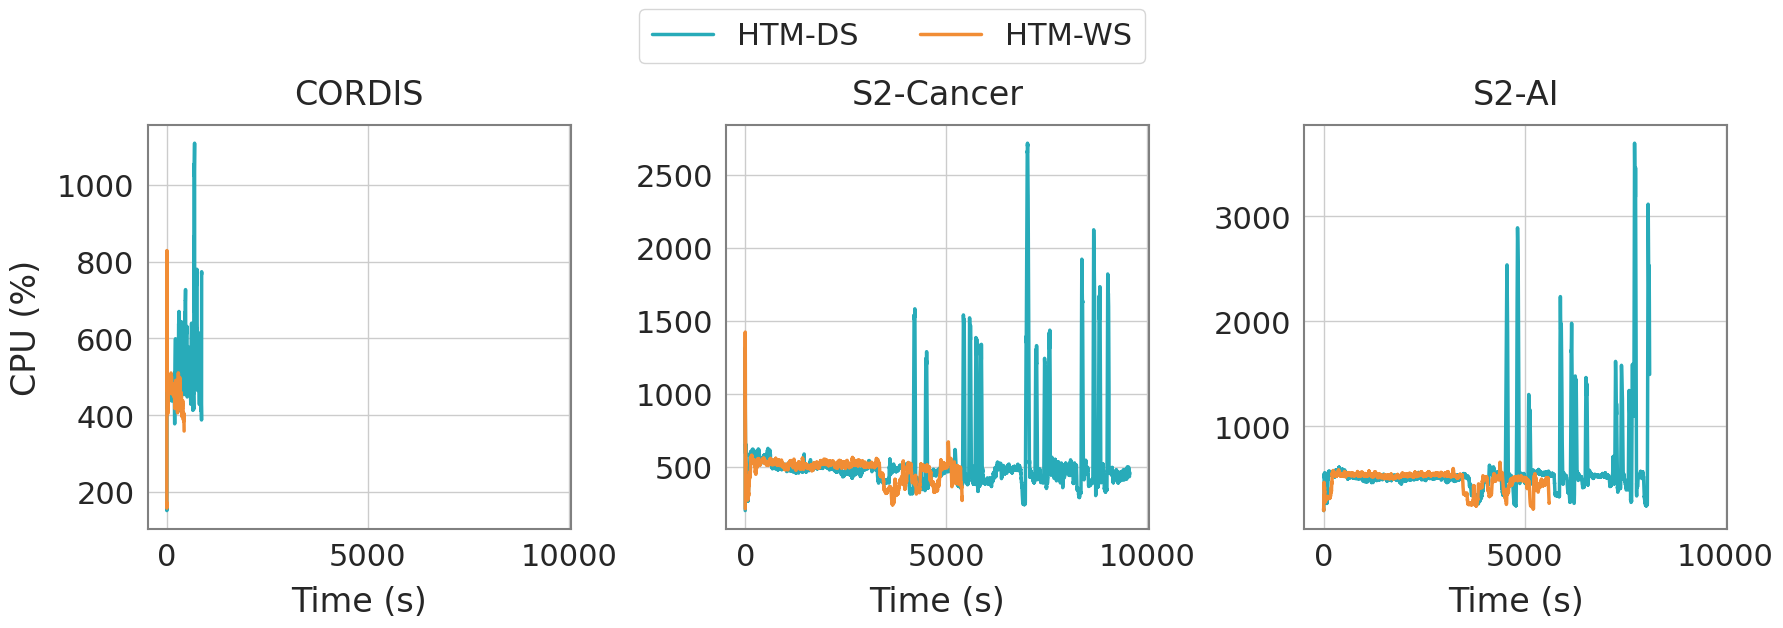

In [49]:
# Procesar los datos
# Diccionario para mapear nombres de archivos a nombres bonitos
algorithm_names = {
    "htm-ds": "HTM-DS",
    "htm-ws": "HTM-WS",
}
datset_names = {
    "cordis": "CORDIS",
    "cancer": "S2-Cancer",
    "s2cs-ai": "S2-AI"
}
# Procesar los datos
all_data = []
path_models = "/export/usuarios_ml4ds/lbartolome/Repos/my_repos/UserInLoopHTM/data/our_models"
algorithms = ["htm-ws", "htm-ds"]
datasets = ["cordis", "cancer", "s2cs-ai"]

for algo in algorithms:
    for dtset in datasets:
        exec_time_file = glob.glob(f"{path_models}/{algo}/{dtset}/execution_times.csv")
        if exec_time_file:
            execution_times = pd.read_csv(exec_time_file[0])
            execution_times = execution_times.rename(columns={"Execution Time (s)": "execution_time"})
        else:
            continue

        cpu_files = glob.glob(f"{path_models}/{algo}/{dtset}/cpu_usage_iter.*.csv")
        gpu_files = glob.glob(f"{path_models}/{algo}/{dtset}/gpu_usage_iter.*.csv")
        df_cpu = load_and_truncate(cpu_files, "cpu", execution_times, filter_window, scale_factor=96)
        df_gpu = load_and_truncate_gpu(gpu_files, "gpu", execution_times, filter_window, num_gpus=3)

        df_combined = pd.merge(df_cpu, df_gpu, on="time_instant", how="outer").fillna(0)
        df_combined["algorithm"] = algorithm_names[algo]  # Usar nombres formateados
        df_combined["dataset"] = dtset
        all_data.append(df_combined)

usage_data = pd.concat(all_data, ignore_index=True)

fig, axs = plt.subplots(1, len(datasets), figsize=(18, 6), sharex=True, sharey=False)  # Solo una fila para CPU

for col, dataset in enumerate(datasets):
    subset = usage_data[usage_data["dataset"] == dataset]
    ax_cpu = axs[col]  # Solo eje para CPU

    for i, algo in enumerate(algorithm_names.values()):
        algo_data = subset[subset["algorithm"] == algo]
        algo_data_zoom = algo_data  # Filtra si quieres limitar el tiempo en eje X
        
        # CPU (línea sólida)
        sns.lineplot(
            data=algo_data_zoom, x="time_instant", y="cpu", ax=ax_cpu, 
            color=palette[i], linewidth=linewidth, label=algo if col == 0 else None
        )

    # Configurar etiquetas y título
    if col == 0:
        ax_cpu.set_ylabel("CPU (%)", fontsize=axis_label_size, labelpad=10)
    else:
        ax_cpu.set_ylabel("")

    if ax_cpu.get_legend() is not None:
        ax_cpu.get_legend().remove()

    ax_cpu.set_xlabel("Time (s)", fontsize=axis_label_size, labelpad=10)
    ax_cpu.set_title(f"{datset_names[dataset]}", fontsize=title_size, pad=15)
    ax_cpu.tick_params(axis='both', labelsize=tick_label_size)

# Leyenda global
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=4, fontsize=legend_size)

# Ajustes finales
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("cpu_usage_ours.png", dpi=300, bbox_inches="tight")
plt.show()

In [50]:
import pandas as pd

# Crear la tabla base con promedios y desviación estándar
summary_table = usage_data.groupby(["algorithm", "dataset"]).agg(
    avg_cpu_usage=("cpu", "mean"),
    std_cpu_usage=("cpu", "std"),
    avg_time=("time_instant", "max")
).reset_index()

# Redondear valores
summary_table["avg_cpu_usage"] = summary_table["avg_cpu_usage"].round(2)
summary_table["std_cpu_usage"] = summary_table["std_cpu_usage"].round(2)
summary_table["avg_time"] = (summary_table["avg_time"] / 60).round(3)

# Crear columna combinada para CPU Usage con desviación estándar
summary_table["cpu_usage"] = summary_table.apply(
    lambda row: f"{row['avg_cpu_usage']} ± {row['std_cpu_usage']}", axis=1
)

# Reformatear la tabla manualmente
datasets = summary_table["dataset"].unique()
algorithms = summary_table["algorithm"].unique()

# Crear la tabla final
final_table = pd.DataFrame(index=algorithms)

for dataset in datasets:
    cpu_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm")["cpu_usage"]
    time_col = summary_table[summary_table["dataset"] == dataset].set_index("algorithm")["avg_time"]
    final_table[(dataset, "CPU Usage")] = cpu_col
    final_table[(dataset, "Time (min)")] = time_col

# Reconstruir el MultiIndex
final_table.columns = pd.MultiIndex.from_tuples(final_table.columns)

# Generar LaTeX manualmente con ajustes
latex_output = "\\begin{table}\n"
latex_output += "\\caption{Consumo total promedio de CPU con desviación estándar y tiempo de ejecución por modelo y dataset}\n"
latex_output += "\\label{tab:cpu_usage_with_std}\n"
latex_output += "\\centering\n"
latex_output += "\\resizebox{\\columnwidth}{!}{%\n"
latex_output += "\\begin{tabular}{llrlrlr}\n"
latex_output += "\\toprule\n"

# Añadir encabezados centrados
datasets_latex = " & ".join([f"\\multicolumn{{2}}{{c}}{{{dataset}}}" for dataset in datasets])
latex_output += f" & {datasets_latex} \\\\\n"

# Añadir líneas horizontales debajo de los encabezados
latex_output += "\\cmidrule(lr){2-3} \\cmidrule(lr){4-5} \\cmidrule(lr){6-7}\n"

# Añadir nombres de columnas secundarias
latex_output += " & CPU Usage & Time (min) & CPU Usage & Time (min) & CPU Usage & Time (min) \\\\\n"
latex_output += "\\midrule\n"

# Añadir datos de la tabla
for algorithm in algorithms:
    row = final_table.loc[algorithm].values
    row_str = " & ".join([str(cell) for cell in row])
    latex_output += f"{algorithm} & {row_str} \\\\\n"

# Finalizar la tabla
latex_output += "\\bottomrule\n"
latex_output += "\\end{tabular}%\n"
latex_output += "}\n"
latex_output += "\\end{table}"

# Guardar en archivo
with open("cpu_usage_std_table.tex", "w") as f:
    f.write(latex_output)

# Mostrar en consola
print(latex_output)

\begin{table}
\caption{Consumo total promedio de CPU con desviación estándar y tiempo de ejecución por modelo y dataset}
\label{tab:cpu_usage_with_std}
\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{llrlrlr}
\toprule
 & \multicolumn{2}{c}{cancer} & \multicolumn{2}{c}{cordis} & \multicolumn{2}{c}{s2cs-ai} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7}
 & CPU Usage & Time (min) & CPU Usage & Time (min) & CPU Usage & Time (min) \\
\midrule
HTM-DS & 534.17 ± 264.9 & 159.45 & 511.91 ± 107.24 & 14.467 & 592.9 ± 374.87 & 135.2 \\
HTM-WS & 480.97 ± 72.77 & 89.967 & 455.83 ± 43.05 & 7.183 & 486.74 ± 84.41 & 93.533 \\
\bottomrule
\end{tabular}%
}
\end{table}
